# **Spit some [tensor] flow**

We need to learn the intricacies of tensorflow to master deep learning

`Let's get this over with`



In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
print(tf.__version__)

2.2.0


## We already have 

N = Number of Samples
D = Number of features or the dimensions 

How will we represent the time-axis? By T


Our dataset will not be N x D now, it will be N x T x D 

In TF and Keras, we usually deal with equal length sequences. Let's talk about:

## Stocks

We have one stock price so D = 1

To have a signal where D is greater than 1, we must have different inputs, e.g., GPS longitude and latitude 

T will give us the window size of area-of-interest. This is the area we look at, to predict the next value

N will be the number of windows in the time series

Thus, for a sequence of length L and a window size of T, we have N = L - T + 1

What if we have D=200, i.e., we are looking at 200 stock prices at the same time

Window size = T 
Stocks we watch = D 
Sample size = T x D 

Total samples = N = L - T + 1

We need data to be N x T x D because this is the pythonista staandard! 

We use N x D for tabular data and N x H x W x C for images; N always corresponds to the samples, D is always the number of features, H is the height, W the width and C the channels; they can either be colors, or the # of feature maps in between CNN layers



## Forecasting 

Forecasting refers to the prediction of next values in the time series. The length of prediction is the horizon i.e., if I want to predict the weather every 2 hours for the next 5 days; I will get a horizon of 5 * 24 = 120 ---> 120/2 = 60 steps


## Total windows 

For length L 10 

Window size T 4

N = L - T + 1

N = 10 - 4 + 1

N = 6 + 1

N = 7

Let's check them out! 

1 2 3 4 5 6 7 8 9 10 -------> Full sequence

```
1 2 3 4 -----> 1

  2 3 4 5 -----> 2

    3 4 5 6 -----> 3

      4 5 6 7 -----> 4

        5 6 7 8 -----> 5

          6 7 8 9 -----> 6

            7 8 9 10 -----> 7
```
But wait a minute, isn't 10 the sample number we are using as the Y variable? We can not use that, thus total number of windows = L - T =  10 - 4 = 6


## How do we predict the time series? 

Well now we're going to go into the details of the implementation; 

```
x_pred_t = w0 + w1 * x_t-1 + w2 * x_t-2 + w3 * x_t-3 + w4 * x_t-4

x_pred_t+1 = w0 + w1 * x_pred_t + w2 * x_t-1 + w3 * x_t-2 + w4 * x_t-3
```

This is an autoregressive model now. 

```
x_pred_5 = w0 + w1 * x_4 + w2 * x_3 + w3 * x_2 + w4 * x_1

x_pred_6 = w0 + w1 * x_pred_5 + w2 * x_4 + w3 * x_3 + w4 * x_2

```


In [0]:
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adamax

## Let's get some synthetic data

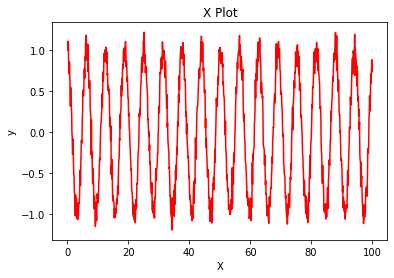

In [104]:
n = 1001
x = 0.1 * np.arange(1,n)
data = np.cos(x) + np.random.randn(n-1) * 0.1

# Visualising the dataset
plt.plot(x, data, color = 'red')
plt.title('X Plot')
plt.xlabel('X')
plt.ylabel('y')
plt.show()


In [105]:
T = 20
D = 1
X = []
y = []
print(len(data))  
print("The last sample would be: " + str(len(data)) + " - " + str(T) + " = " + str((len(data)-T)) )
print("BUT data[1000] can not be used! so, we must go from 1 to 979 ")

1000
The last sample would be: 1000 - 20 = 980
BUT data[1000] can not be used! so, we must go from 1 to 979 


In [0]:
for i in range(len(data) - T):
  x = data[i:i+T]
  X.append(x)
  y_temp = data[i+T]
  y.append(y_temp)

In [0]:
# Since we need an N x T x D input
X = np.array(X).reshape(-1, T, D) 
y = np.array(y)

In [108]:
print(X.shape)
print(y.shape)

N, T, D = X.shape

(980, 20, 1)
(980,)


In [0]:
i_layer = Input(shape = (T, D))
h_layer = SimpleRNN(4)(i_layer)
o_layer = Dense(1)(h_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.1))

In [110]:
index = -N//2
report = model.fit(X[:index], y[:index], epochs=50, validation_data=(X[index:], y[index:]))

Epoch 1/50
16/16 [==============================] - 0s 25ms/step - loss: 0.0760 - val_loss: 0.0271
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0280 - val_loss: 0.0231
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0253 - val_loss: 0.0297
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0263 - val_loss: 0.0259
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0284 - val_loss: 0.0250
Epoch 6/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0267 - val_loss: 0.0350
Epoch 7/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0260 - val_loss: 0.0223
Epoch 8/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0232 - val_loss: 0.0274
Epoch 9/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0251 - val_loss: 0.0233
Epoch 10/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0265 - val_loss: 0.0294
Epoch 11/

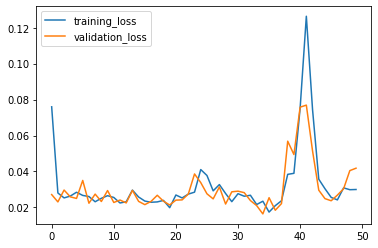

In [111]:
plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

In [0]:
y_test = y[index:]
y_pred = []

In [0]:
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred

In [114]:
print(len(y_pred))
print(len(y_test))

490
490


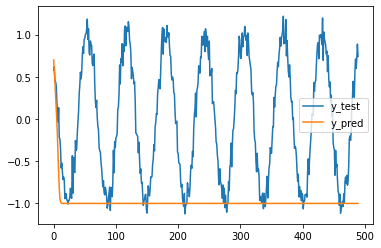

In [115]:
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()

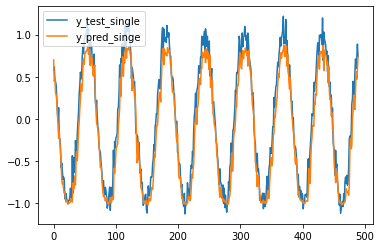

In [116]:
y_test_single = y[index:]
y_pred_single = []

i = index
while len(y_pred_single) < len(y_test_single):
  pred = model.predict(X[i].reshape(1,T, D))[0,0]
  i+=1
  y_pred_single.append(pred)

plt.plot(y_test_single, label='y_test_single')
plt.plot(y_pred_single, label='y_pred_singe')
plt.legend()

## This is bad, the single prediction shows that our model just copies the previous value, this is bad bad bad

But we're in too deep in the world of deep learning, we must find a way! Let's fix our window


1000
The last sample would be: 1000 - 200 = 800
Epoch 1/50
18/18 [==============================] - 2s 114ms/step - loss: 2.4839 - val_loss: 0.5530
Epoch 2/50
18/18 [==============================] - 2s 113ms/step - loss: 0.9256 - val_loss: 0.7806
Epoch 3/50
18/18 [==============================] - 2s 106ms/step - loss: 0.5700 - val_loss: 0.9677
Epoch 4/50
18/18 [==============================] - 2s 106ms/step - loss: 0.5831 - val_loss: 0.5746
Epoch 5/50
18/18 [==============================] - 2s 108ms/step - loss: 0.5044 - val_loss: 0.8263
Epoch 6/50
18/18 [==============================] - 2s 107ms/step - loss: 0.6952 - val_loss: 0.8813
Epoch 7/50
18/18 [==============================] - 2s 111ms/step - loss: 0.6604 - val_loss: 0.4911
Epoch 8/50
18/18 [==============================] - 2s 105ms/step - loss: 0.5145 - val_loss: 0.4706
Epoch 9/50
18/18 [==============================] - 2s 105ms/step - loss: 0.5608 - val_loss: 0.4738
Epoch 10/50
18/18 [==============================] -

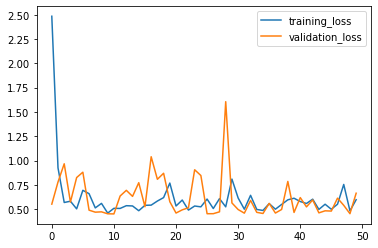

In [142]:
T = 200
D = 1
X = []
y = []
print(len(data))  
print("The last sample would be: " + str(len(data)) + " - " + str(T) + " = " + str((len(data)-T)) )

for i in range(len(data) - T):
  x = data[i:i+T]
  X.append(x)
  y_temp = data[i+T]
  y.append(y_temp)

X = np.array(X).reshape(-1, T, D) 
y = np.array(y)

i_layer = Input(shape = (T, D))
h_layer = SimpleRNN(30, activation='tanh')(i_layer)
o_layer = Dense(1)(h_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.2))

index = -N//4
report = model.fit(X[:index], y[:index], epochs=50, validation_data=(X[index:], y[index:]))

plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

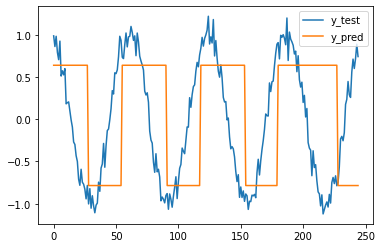

In [143]:
y_test = y[index:]
y_pred = []
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()

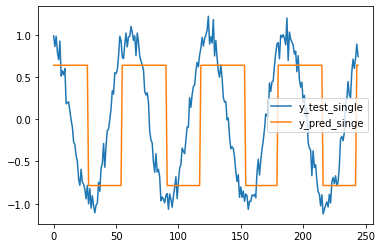

In [144]:
y_test_single = y[index:]
y_pred_single = []

i = index
while len(y_pred_single) < len(y_test_single):
  pred = model.predict(X[i].reshape(1,T, D))[0,0]
  i+=1
  y_pred_single.append(pred)

plt.plot(y_test_single, label='y_test_single')
plt.plot(y_pred_single, label='y_pred_singe')
plt.legend()

## So it goes; the RNN fails ! Let's try again with a linear model


1000
The last sample would be: 1000 - 150 = 850
Epoch 1/50
19/19 [==============================] - 0s 5ms/step - loss: 8.8892 - val_loss: 0.2882
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 1.6537 - val_loss: 0.6356
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 0.3409 - val_loss: 0.1228
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0608 - val_loss: 0.0547
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0543
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0383 - val_loss: 0.0286
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0479
Epoch 8/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0321
Epoch 9/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0284 - val_loss: 0.0241
Epoch 10/50
19/19 [==============================] - 0s 3ms/step - los

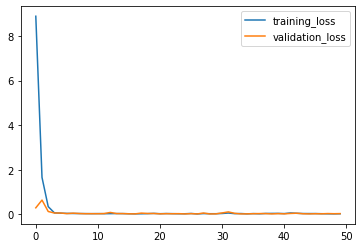

In [161]:
T = 150
D = 1
X = []
y = []
print(len(data))  
print("The last sample would be: " + str(len(data)) + " - " + str(T) + " = " + str((len(data)-T)) )

for i in range(len(data) - T):
  x = data[i:i+T]
  X.append(x)
  y_temp = data[i+T]
  y.append(y_temp)

X = np.array(X).reshape(-1, T) 
y = np.array(y)

i_layer = Input(shape = (T))
o_layer = Dense(1)(i_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.1))

index = -N//4
report = model.fit(X[:index], y[:index], epochs=50, validation_data=(X[index:], y[index:]))

plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

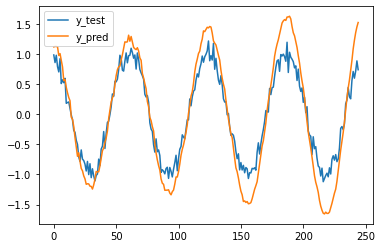

In [162]:
y_test = y[index:]
y_pred = []
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()

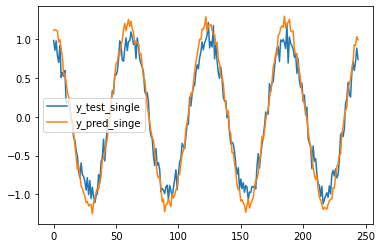

In [164]:
y_test_single = y[index:]
y_pred_single = []

i = index
while len(y_pred_single) < len(y_test_single):
  pred = model.predict(X[i].reshape(1,T, D))[0,0]
  i+=1
  y_pred_single.append(pred)

plt.plot(y_test_single, label='y_test_single')
plt.plot(y_pred_single, label='y_pred_singe')
plt.legend()